In [48]:
import copy

import numpy as np
from scipy.linalg.lapack import zheevd, zheev

import sympy as smp
import matplotlib.pyplot as plt

from centrex_tlf import states, couplings, transitions, hamiltonian, lindblad

from state_prep import electric_fields

In [2]:
plt.rcParams.update({f"font.size": 14})

In [3]:
Ez = electric_fields.Ez_from_csv()

In [4]:
X_states_uncoupled = states.generate_uncoupled_states_ground(Js=[0, 1, 2])

ham_uncoupled = hamiltonian.generate_uncoupled_hamiltonian_X(X_states_uncoupled)
ham_func = hamiltonian.generate_uncoupled_hamiltonian_X_function(ham_uncoupled)

# Microwave couplings

In [5]:
X_states_coupled = [qn.transform_to_coupled() for qn in X_states_uncoupled]
full_dmat = couplings.generate_coupling_matrix(
    X_states_coupled,
    X_states_coupled[:4],
    X_states_coupled[4:16],
    np.array([0, 0, 1], dtype=np.complex128),
)

In [ ]:
from tqdm import tqdm
from scipy.linalg.lapack import zheevd


def find_max_overlap_idx(state_vec: np.ndarray, V_matrix: np.ndarray) -> int:
    # Take dot product between each eigenvector in V and state_vec
    overlap_vectors = np.absolute(V_matrix.conj().T @ state_vec)

    # Find index of state that has the largest overlap
    index = np.argmax(overlap_vectors)

    return index


def reorder_evecs(
    V_in: np.ndarray, E_in: np.ndarray, V_ref: np.ndarray
) -> tuple[np.ndarray]:
    """
    Reorders the matrix of eigenvectors V_in (each column is an eigenvector) and
    corresponding energies E_in so that the eigenvector overlap between V_in and V_ref
    is maximised.
    """
    # Take dot product between each eigenvector in V and state_vec
    overlap_vectors = np.absolute(np.matmul(np.conj(V_in.T), V_ref))

    # Find which state has the largest overlap:
    index = np.argsort(np.argmax(overlap_vectors, axis=1))
    # Store energy and state

    E_out = E_in[index]
    V_out = V_in[:, index]

    return E_out, V_out


def vector_to_state(state_vector, QN, E=None):
    state = states.UncoupledState([])

    # Get data in correct format for initializing state object
    for j, amp in enumerate(state_vector):
        state += amp * QN[j]

    return state


def init_state_vecs(initial_states_approx, QN, H_0) -> None:
    """
    Generates state vectors based on self.initial_states in the basis
    of self.hamiltonian
    """

    # Find the eigenstates of the Hamiltonian that most closely correspond to the
    # initial states
    initial_states = []
    psis = []
    _, V = np.linalg.eigh(H_0)
    for state in initial_states_approx:
        idx = find_max_overlap_idx(state.state_vector(QN), V)
        psis.append(V[:, idx])
        initial_states.append(vector_to_state(V[:, idx], QN))
    psis = np.array(psis)
    initial_states = initial_states
    return initial_states, psis


def calculate_probabilities(psis: np.ndarray, V: np.ndarray) -> np.ndarray:
    """
    Given state vectors as columns of psi, for each state vector, returns the
    probabilities of being in states stored as columns of V.
    """
    # overlaps_list = []
    # for psi in psis:
    #     overlaps_list.append(V.conj().T @ psi)
    # overlaps = np.array(overlaps_list)

    overlaps = np.einsum("ij,kj->ki", V.conj().T, psis)

    return np.abs(overlaps) ** 2


def init_results_containers(
    psis: np.ndarray,
    n_initial_states: int,
    n_states: int,
    t_array: np.ndarray,
    H_tini: np.ndarray,
):
    """
    Initializes containers for time evolution results based on array of times
    and Hamiltonian at initial time.
    """
    # Storage for state vectors
    psis_t = np.zeros(
        (len(t_array), n_initial_states, n_states),
        dtype="complex",
    )
    psis_t[0, :, :] = psis

    # Storage for energies
    energies = np.zeros((len(t_array), n_states))

    # Storage for state probabilities
    probabilities = np.zeros(psis_t.shape)

    # Calculate values for energies and probabilities at t_ini
    D, V = np.linalg.eigh(H_tini)

    # Store values
    energies[0, :] = D
    probabilities[0, :, :] = calculate_probabilities(psis, V)

    return psis_t, energies, probabilities


def _time_evolve_mu(
    initial_states_approx,
    H_slow_t,
    H_mu_t,
    D_mu,
    t_array,
    QN,
):
    """
    Time evolves the system using the Hamiltonian function H_t
    over the time period in t_array.
    """
    # Calculate Hamiltonian at tini
    H_tini = H_slow_t(t_array[0])

    # Initialize state vectors
    initial_states, psis = init_state_vecs(initial_states_approx, QN, H_tini)

    # Initialize containers to store results
    psis_t, energies, probabilities = init_results_containers(
        psis, len(initial_states), len(QN), t_array, H_tini
    )

    # Initialize reference matrix of eigenvectors that is used to keep track
    # of adiabatic evolution of eigenstates
    E_ref, V_ref = np.linalg.eigh(H_tini)
    index = np.argsort(E_ref)
    E_ref = E_ref[index]
    V_ref = V_ref[:, index]
    V_ref_ini = V_ref.copy()

    # Loop over t_array to time-evolve
    for i, t in enumerate(tqdm(t_array[1:])):
        # Calculate the timestep
        dt = t_array[i + 1] - t_array[i]

        # Calculate Hamiltonians
        H_slow_i = H_slow_t(t)
        H_mu_i = H_mu_t(t)

        # Diagonalize slow Hamiltonian and transfer to basis where it is
        # diagonal
        D, V, info = zheevd(H_slow_i)
        if info != 0:
            D, V = np.linalg.eigh(H_slow_i)

        # Sort the eigenvalues so they are in ascending order
        # index = np.argsort(D)
        # D = D[index]
        # V = V[:, index]

        # Reorder eigenvectors and energies
        Esort, Vsort = reorder_evecs(V, D, V_ref)

        # Make Hamiltonian in rotating frame
        H_rot = V.conj().T @ (H_slow_i + H_mu_i) @ V + D_mu

        # Diagonalize the Hamiltonian in the rotating frame
        D_rot, V_rot, info_rot = zheevd(H_rot)
        if info_rot != 0:
            print("zheevd didn't work for H_rot")
            D_rot, V_rot = np.linalg.eigh(H_rot)

        # Compute the propagator
        # Combine the unitary matrices
        A = V @ V_rot

        # Compute the phase factors as a 1D array (no diag creation)
        phase = np.exp(-1j * D_rot * dt)

        # Multiply each column of A by the corresponding phase factor using broadcasting.
        # A_phase is equivalent to A @ np.diag(phase)
        A_phase = A * phase[np.newaxis, :]

        # Compute U_dt without explicitly forming a diagonal matrix.
        U_dt = A_phase @ A.conj().T

        # Apply propagator to each state vector
        psis = psis.dot(U_dt.T)

        # Store results for this timestep
        psis_t[i + 1, :, :] = psis
        energies[i + 1, :] = Esort
        probabilities[i + 1, :, :] = calculate_probabilities(psis, Vsort)

        # Change V_ref
        V_ref = evecs

    return psis_t, energies, probabilities, V_ref_ini, V_ref

In [29]:
vz = 184
z0 = -0.25
zstop = 0.2
tmax = (zstop - z0) / vz
σμ = 1.078e-2
zμ0 = 0.0
zμ1 = 25.4e-3 * 1.125
Γ = 2 * np.pi * 1.56e6

cpl = full_dmat.copy()
cpl[np.abs(cpl) < 1e-6] = 0.0


def ham_slow_t(t):
    return ham_func([0, 0, Ez(z0 + vz * t)], [0, 0, 1e-5])


def gaussian_peak(x, mu=0.0, sigma=1.0):
    delta = x - mu
    return np.exp(-0.5 * (delta / sigma) ** 2)


def ham_mu_t(t):
    return cpl * gaussian_peak(z0 + vz * t, mu=zμ0, sigma=σμ) / 2 * 1e-1 * Γ


D_mu = np.zeros(full_dmat.shape, dtype=np.complex128)
for i in range(4, 16):
    D_mu[i, i] = -83817990535.81007

In [31]:
Hresonance = ham_func([0, 0, Ez(0)], [0, 0, 1e-5])
E, _, info = zheevd(Hresonance)
print(info)
print(E[13] - E[1])

0
83817990535.81007


In [30]:
# Define some useful approximate states
J0_singlet = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=+1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        - 1
        * states.UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=+1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J0_triplet_0 = (
    1
    / np.sqrt(2)
    * (
        1
        * states.UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=1 / 2,
            I2=1 / 2,
            m2=-1 / 2,
            P=+1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
        + 1
        * states.UncoupledBasisState(
            J=0,
            mJ=0,
            I1=1 / 2,
            m1=-1 / 2,
            I2=1 / 2,
            m2=1 / 2,
            P=+1,
            Omega=0,
            electronic_state=states.ElectronicState.X,
        )
    )
)

J0_triplet_p = 1 * states.UncoupledBasisState(
    J=0,
    mJ=0,
    I1=1 / 2,
    m1=1 / 2,
    I2=1 / 2,
    m2=1 / 2,
    P=+1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

J0_triplet_m = 1 * states.UncoupledBasisState(
    J=0,
    mJ=0,
    I1=1 / 2,
    m1=-1 / 2,
    I2=1 / 2,
    m2=-1 / 2,
    P=+1,
    Omega=0,
    electronic_state=states.ElectronicState.X,
)

initial_states_approx = [J0_singlet, J0_triplet_m, J0_triplet_0, J0_triplet_p]


In [32]:
t_array = np.linspace(0, tmax, 10001)

In [52]:
psis_t, energies, probabilities, V_ref_ini, V_ref = _time_evolve_mu(
    initial_states_approx, ham_slow_t, ham_mu_t, D_mu, t_array, X_states_uncoupled
)

100%|██████████| 10000/10000 [00:08<00:00, 1194.89it/s]


[ 3 10]


1.00+0.00j x |X, J = 0, F₁ = 1/2, F = 0, mF = 0, I₁ = 1/2, I₂ = 1/2, P = +, Ω = 0>

1.00+0.00j x |X, J = 1, F₁ = 3/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
-0.09+0.00j x |X, J = 1, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>

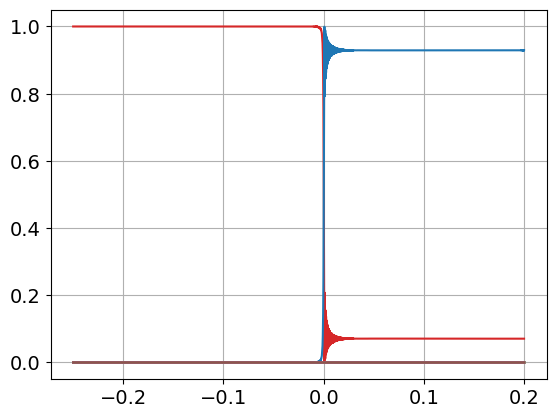

In [165]:
idi = 0

fig, ax = plt.subplots()
ax.plot(t_array * vz + z0, probabilities[:, idi, :])
ax.grid()

pfinal = probabilities[-1, idi, :].copy()
pfinal[pfinal < 1e-2] = 0.0
print(np.nonzero(pfinal)[0])

display(
    vector_to_state(
        V_ref_ini[:, np.nonzero(pfinal)[0][0]], X_states_uncoupled
    ).transform_to_coupled()
)
display(
    vector_to_state(
        V_ref_ini[:, np.nonzero(pfinal)[0][1]], X_states_uncoupled
    ).transform_to_coupled()
)

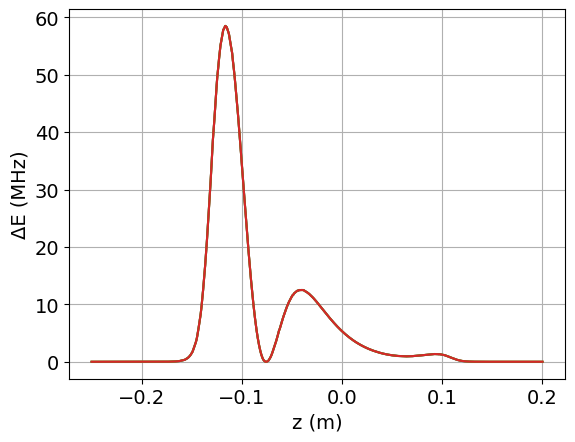

In [61]:
H0 = ham_func([0, 0, 0], [0, 0, 1e-5])
E0, _, info = zheevd(H0)
ω = E0[13] - E0[1]

fig, ax = plt.subplots()

for idi in range(4):
    pfinal = probabilities[-1, idi, :].copy()
    pfinal[pfinal < 1e-2] = 0.0
    idg, ide = np.nonzero(pfinal)[0]

    ax.plot(
        t_array * vz + z0, (energies[:, ide] - energies[:, idg] - ω) / (2 * np.pi * 1e6)
    )

ax.set_xlabel("z (m)")
ax.set_ylabel("ΔE (MHz)")
ax.grid()

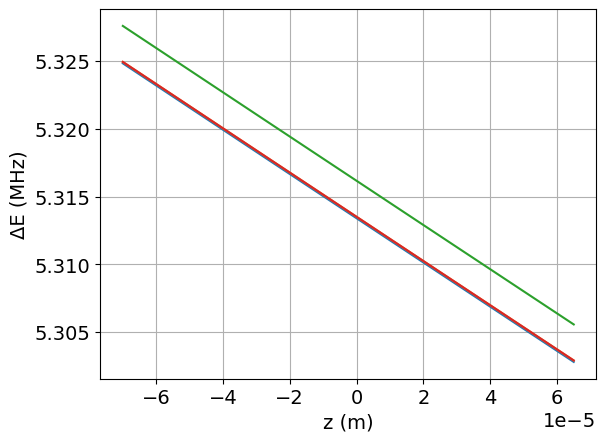

In [67]:
H0 = ham_func([0, 0, 0], [0, 0, 1e-5])
E0, _, info = zheevd(H0)
ω = E0[13] - E0[1]

fig, ax = plt.subplots()

zs = t_array * vz + z0
mask = (zs > -1e-4) & (zs < 1e-4)

for idi in range(4):
    pfinal = probabilities[-1, idi, :].copy()
    pfinal[pfinal < 1e-2] = 0.0
    idg, ide = np.nonzero(pfinal)[0]

    ax.plot(
        zs[mask], (energies[:, ide] - energies[:, idg] - ω)[mask] / (2 * np.pi * 1e6)
    )

ax.set_xlabel("z (m)")
ax.set_ylabel("ΔE (MHz)")
ax.grid()

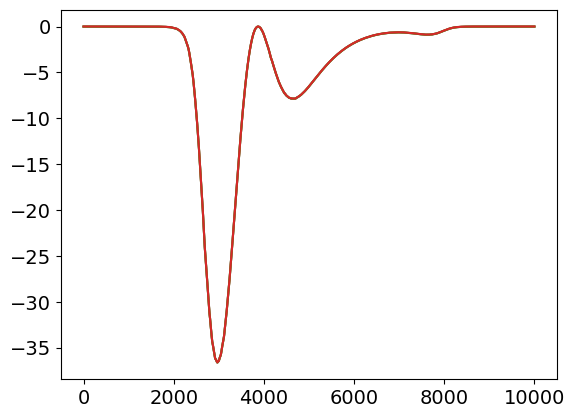

In [ ]:
fig, ax = plt.subplots()
ax.plot(energies[:, :4] / (2 * np.pi * 1e6))

In [85]:
for idx in range(16):
    s = (
        vector_to_state(V_ref_ini[:, idx], X_states_uncoupled)
        .transform_to_coupled()
        .largest
    )
    s = s.state_string_custom(["J", "F1", "F", "mF"])
    print(f"{idx:>2} -> {s}")

 0 -> |J = 0, F1 = 1/2, F = 1, mF = 1>
 1 -> |J = 0, F1 = 1/2, F = 1, mF = 0>
 2 -> |J = 0, F1 = 1/2, F = 1, mF = -1>
 3 -> |J = 0, F1 = 1/2, F = 0, mF = 0>
 4 -> |J = 1, F1 = 1/2, F = 0, mF = 0>
 5 -> |J = 1, F1 = 1/2, F = 1, mF = 0>
 6 -> |J = 1, F1 = 1/2, F = 1, mF = 1>
 7 -> |J = 1, F1 = 1/2, F = 1, mF = -1>
 8 -> |J = 1, F1 = 3/2, F = 1, mF = -1>
 9 -> |J = 1, F1 = 3/2, F = 1, mF = 1>
10 -> |J = 1, F1 = 3/2, F = 1, mF = 0>
11 -> |J = 1, F1 = 3/2, F = 2, mF = 2>
12 -> |J = 1, F1 = 3/2, F = 2, mF = -2>
13 -> |J = 1, F1 = 3/2, F = 2, mF = 1>
14 -> |J = 1, F1 = 3/2, F = 2, mF = -1>
15 -> |J = 1, F1 = 3/2, F = 2, mF = 0>


In [ ]:
# check sigma+ indices
sigmap_transitions = []
for idx in range(4):
    sg = vector_to_state(V_ref_ini[:, idx], X_states_uncoupled).transform_to_coupled()
    sgs = sg.state_string_custom(["J", "F1", "F", "mF"]).strip("\n")
    for idy in range(4, 16):
        se = vector_to_state(
            V_ref_ini[:, idy], X_states_uncoupled
        ).transform_to_coupled()
        ses = se.state_string_custom(["J", "F1", "F", "mF"]).strip("\n")
        me = couplings.calculate_ED_ME_mixed_state(
            se, sg, pol_vec=couplings.polarization.polarization_σp.vector
        )
        if me > 1e-3:
            sigmap_transitions.append((idx, idy))
            print(f"{idx} -> {idy:>2} : {me:.3f}")
            print(f"{sgs}")
            print(f"{ses}")
            print("=" * 50)

0 -> 11 : 0.577+0.000j
-1.00+0.00j x |J = 0, F1 = 1/2, F = 1, mF = 1>
-1.00+0.00j x |J = 1, F1 = 3/2, F = 2, mF = 2>
1 ->  6 : 0.353+0.000j
1.00+0.00j x |J = 0, F1 = 1/2, F = 1, mF = 0>
1.00+0.00j x |J = 1, F1 = 1/2, F = 1, mF = 1>
0.09+0.00j x |J = 1, F1 = 3/2, F = 1, mF = 1>
1 -> 13 : 0.408+0.000j
1.00+0.00j x |J = 0, F1 = 1/2, F = 1, mF = 0>
1.00+0.00j x |J = 1, F1 = 3/2, F = 2, mF = 1>
2 ->  4 : 0.333+0.000j
1.00+0.00j x |J = 0, F1 = 1/2, F = 1, mF = -1>
1.00+0.00j x |J = 1, F1 = 1/2, F = 0, mF = 0>
2 ->  5 : 0.353+0.000j
1.00+0.00j x |J = 0, F1 = 1/2, F = 1, mF = -1>
1.00+0.00j x |J = 1, F1 = 1/2, F = 1, mF = 0>
0.09+0.00j x |J = 1, F1 = 3/2, F = 1, mF = 0>
2 -> 10 : 0.205+0.000j
1.00+0.00j x |J = 0, F1 = 1/2, F = 1, mF = -1>
1.00+0.00j x |J = 1, F1 = 3/2, F = 1, mF = 0>
-0.09+0.00j x |J = 1, F1 = 1/2, F = 1, mF = 0>
2 -> 15 : 0.236+0.000j
1.00+0.00j x |J = 0, F1 = 1/2, F = 1, mF = -1>
1.00+0.00j x |J = 1, F1 = 3/2, F = 2, mF = 0>


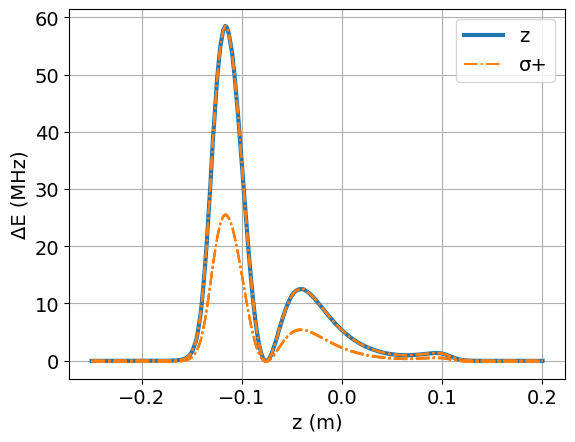

In [163]:
H0 = ham_func([0, 0, 0], [0, 0, 1e-5])
E0, _, info = zheevd(H0)
ω = E0[13] - E0[1]

zs = t_array * vz + z0

fig, ax = plt.subplots()

# Z polarized
for idi in range(4):
    pfinal = probabilities[-1, idi, :].copy()
    pfinal[pfinal < 1e-2] = 0.0
    idg, ide = np.nonzero(pfinal)[0]

    ax.plot(
        zs,
        (energies[:, ide] - energies[:, idg] - ω) / (2 * np.pi * 1e6),
        label="z",
        color="C0",
        lw=3,
    )
    break

# sigma+ polarized
for idg, ide in sigmap_transitions:
    # sg = (
    #     vector_to_state(V_ref_ini[:, idg], X_states_uncoupled)
    #     .transform_to_coupled()
    #     .largest
    # )
    # se = (
    #     vector_to_state(V_ref_ini[:, ide], X_states_uncoupled)
    #     .transform_to_coupled()
    #     .largest
    # )
    # if (se.mF == 0 and se.F in [1, 2] and se.F1 == 1.5) or (se.mF == 1 and se.F == 2):
    #     ls = "--"
    # else:
    #     ls = "-"
    ax.plot(
        zs,
        (energies[:, ide] - energies[:, idg] - ω) / (2 * np.pi * 1e6),
        label=f"σ+",
        ls="-.",
        color="C1",
    )

ax.set_xlabel("z (m)")
ax.set_ylabel("ΔE (MHz)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(
    zip(labels, handles)
)  # Removes duplicates by keeping the last handle per label

ax.legend(by_label.values(), by_label.keys())

ax.grid()

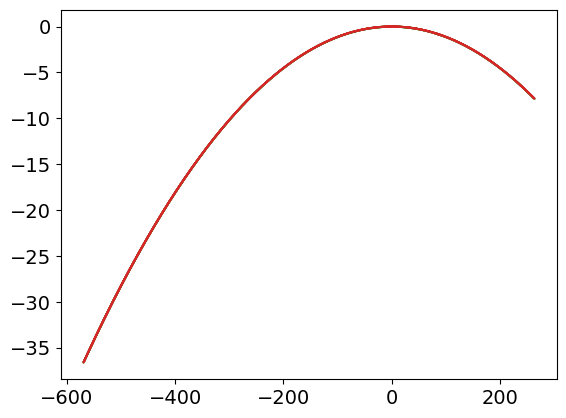

In [124]:
plt.plot(Ez(zs), (energies[:, :4]) / (2 * np.pi * 1e6))

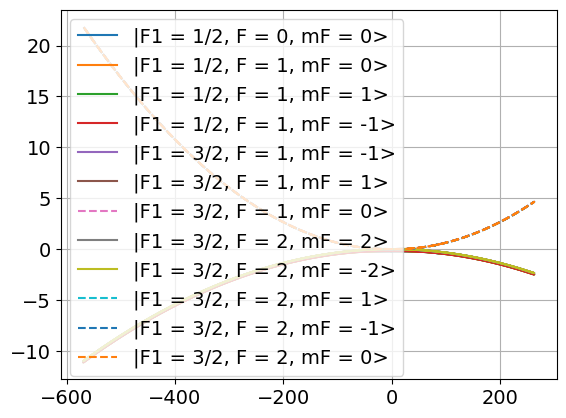

In [152]:
fig, ax = plt.subplots()
for idx in range(4, 16):
    s = (
        vector_to_state(V_ref_ini[:, idx], X_states_uncoupled)
        .transform_to_coupled()
        .largest
    )
    if (s.mF == 0 and s.F in [1, 2] and s.F1 == 1.5) or (s.mF in [-1, 1] and s.F == 2):
        ls = "--"
    else:
        ls = "-"
    s = s.state_string_custom(["F1", "F", "mF"])
    ax.plot(Ez(zs), (energies[:, idx] - ω) / (2 * np.pi * 1e6), label=f"{s}", ls=ls)

ax.legend()
ax.grid()